# EDA and Ensemble Model


Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world

Data Fields

    datetime - hourly date + timestamp
    season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
    holiday - whether the day is considered a holiday
    workingday - whether the day is neither a weekend nor holiday
    weather -
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp - temperature in Celsius
    atemp - "feels like" temperature in Celsius
    humidity - relative humidity
    windspeed - wind speed
    casual - number of non-registered user rentals initiated
    registered - number of registered user rentals initiated
    count - number of total rentals (Dependent Variable)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import missingno as msno
import pylab
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Data Exploration

In [2]:
train = pd.read_csv('../data/bike_train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
train.shape

(10886, 12)

In [4]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
# creating new colums from datetime column
import calendar
train['date'] = train.datetime.apply(lambda x: x.split()[0])
train['hour'] = train.datetime.apply(lambda x: x.split()[1].split(':')[0])
train['weekday'] = train.date.apply(lambda dateString: calendar.day_name[datetime.strptime(
                                                        dateString, "%Y-%m-%d").weekday()])
train['month'] = train.date.apply(lambda dateString: calendar.month_name[datetime.strptime(
                                                        dateString, "%Y-%m-%d").month])
train["season"] = train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train['weather'] = train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [6]:
# coercing to category type
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]

for var in categoryVariableList:
    train[var] = train[var].astype('category')

In [7]:
# droping unncessary column
train = train.drop(['datetime'], axis=1)

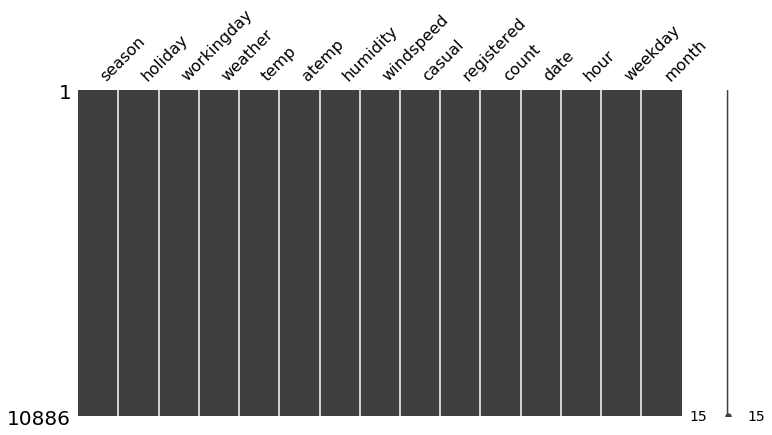

In [9]:
# missing values
msno.matrix(train, figsize=(12,6))

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Workingday'),
 Text(0.5, 1.0, 'Box plot on count label across Working day')]

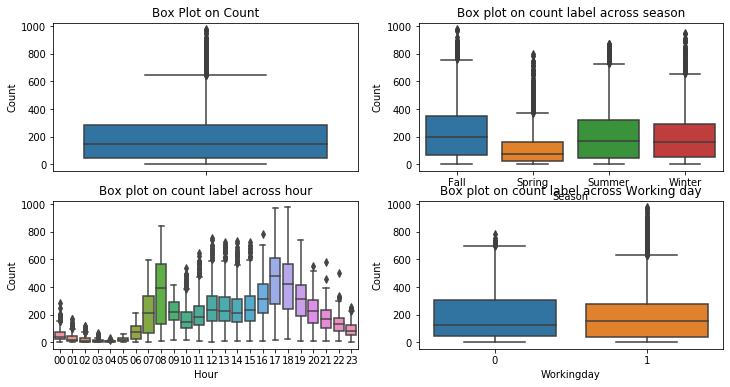

In [11]:
fig,axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12,6)
sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, y='count', x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=train, y='count', x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=train, y='count', x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count',title='Box Plot on Count')
axes[0][1].set(xlabel='Season', ylabel='Count', title='Box plot on count label across season')
axes[1][0].set(xlabel='Hour', ylabel='Count', title='Box plot on count label across hour')
axes[1][1].set(xlabel='Workingday', ylabel='Count', title='Box plot on count label across Working day')

## Ensemble Model Preparation

In [12]:
train = pd.read_csv('../data/bike_train.csv')
test = pd.read_csv('../data/bike_test.csv')

In [13]:
# combine data
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

/Users/kumarujjawal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [18]:
data['date'] = data.datetime.apply(lambda x: x.split()[0])
data['hour'] = data.datetime.apply(lambda x: x.split()[1].split(':')[0]).astype('int')
data['year'] = data.datetime.apply(lambda x: x.split()[0].split('-')[0])
data['weekday'] = data.date.apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").weekday())
data['month'] = data.date.apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").month)

## Random Forest Model

In [19]:
# To predict 0's in Windspeed

from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data['windspeed']==0]
dataWindNot0 = data[data['windspeed']!=0]
rf_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]

rf_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

/Users/kumarujjawal/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
wind0Values = rf_wind.predict(X=dataWind0[windColumns])
dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [21]:
# coercing to categorical type
categoryFeatureNames = ['season','holiday', 'workingday','weather', 'month','year','hour']
numericFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [22]:
for var in categoryFeatureNames:
    data[var] = data[var].astype('category')

In [23]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by='datetime')
dataTest = data[~pd.notnull(data['count'])].sort_values(by='datetime')
datetimecol = dataTest['datetime']
ylabels = dataTrain['count']
ylabelsRegistred = dataTrain['registered']
ylabelsCasual = dataTrain['casual']

In [24]:
# dropping unnecessary columns
dataTrain.drop(dropFeatures, axis=1)
dataTest.drop(dropFeatures, axis=1)

,atemp,holiday,humidity,season,temp,weather,windspeed,workingday,hour,year,weekday,month
9573,11.365,0,56,1,10.66,1,26.002700,1,0,2011,3,1
16512,13.635,0,56,1,10.66,1,8.705935,1,1,2011,3,1
16513,13.635,0,56,1,10.66,1,8.705935,1,2,2011,3,1
9574,12.880,0,56,1,10.66,1,11.001400,1,3,2011,3,1
9575,12.880,0,56,1,10.66,1,11.001400,1,4,2011,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15194,12.880,0,60,1,10.66,2,11.001400,1,19,2012,0,12
15195,12.880,0,60,1,10.66,2,11.001400,1,20,2012,0,12
15196,12.880,0,60,1,10.66,1,11.001400,1,21,2012,0,12
15197,13.635,0,56,1,10.66,1,8.998100,1,22,2012,0,12


### RMSLE Scorer

In [25]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Linear Regression Model

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

reg_model = LinearRegression()

ylabelLog = np.log1p(ylabels)
reg_model.fit(X=dataTrain, y=ylabelLog)

preds = reg_model.predict(X=dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

ValueError: could not convert string to float: '2011-01-01 00:00:00'